In [1]:
from ISLP import confusion_table
from ISLP import load_data
from ISLP.models import (ModelSpec as MS, summarize)
from ISLP.models import contrast

from matplotlib.pyplot import subplots

from sklearn.discriminant_analysis import (LinearDiscriminantAnalysis as LDA, QuadraticDiscriminantAnalysis as QDA)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd
import statsmodels.api as sm

In [2]:
def confusion_stats(t):
    columns = t.columns
    accuracy = (t[columns[0]][columns[0]] + t[columns[1]][columns[1]])/ (t[columns[0]].sum() + t[columns[1]].sum())
    positive_rate = (t[columns[1]][columns[1]]) / t[columns[1]].sum()
    negative_rate = (t[columns[0]][columns[0]]) / t[columns[0]].sum()
    print(f'accuracy: {accuracy}\ntrue positives: {positive_rate}\ntrue_negatives: {negative_rate}')

In [3]:
weekly = load_data('Weekly')
weekly.head()


,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,1990,0.816,1.572,-3.936,-0.229,-3.484,0.154976,-0.270,Down
1,1990,-0.270,0.816,1.572,-3.936,-0.229,0.148574,-2.576,Down
2,1990,-2.576,-0.270,0.816,1.572,-3.936,0.159837,3.514,Up
3,1990,3.514,-2.576,-0.270,0.816,1.572,0.161630,0.712,Up
4,1990,0.712,3.514,-2.576,-0.270,0.816,0.153728,1.178,Up


In [4]:
weekly.corr()

C:\Users\jackt\AppData\Local\Temp\ipykernel_18768\2100277423.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  weekly.corr()


,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
Year,1.000000,-0.032289,-0.033390,-0.030006,-0.031128,-0.030519,0.841942,-0.032460
Lag1,-0.032289,1.000000,-0.074853,0.058636,-0.071274,-0.008183,-0.064951,-0.075032
Lag2,-0.033390,-0.074853,1.000000,-0.075721,0.058382,-0.072499,-0.085513,0.059167
Lag3,-0.030006,0.058636,-0.075721,1.000000,-0.075396,0.060657,-0.069288,-0.071244
Lag4,-0.031128,-0.071274,0.058382,-0.075396,1.000000,-0.075675,-0.061075,-0.007826
Lag5,-0.030519,-0.008183,-0.072499,0.060657,-0.075675,1.000000,-0.058517,0.011013
Volume,0.841942,-0.064951,-0.085513,-0.069288,-0.061075,-0.058517,1.000000,-0.033078
Today,-0.032460,-0.075032,0.059167,-0.071244,-0.007826,0.011013,-0.033078,1.000000


<Axes: >

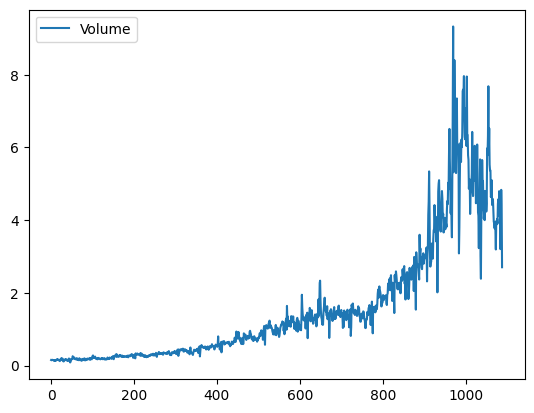

In [5]:
weekly.plot(y='Volume')

In [6]:
feature_df = weekly.drop(columns=['Direction', 'Today', 'Year'])
Direction = weekly['Direction']
X_train, X_test, y_train, y_test = train_test_split(feature_df, Direction, test_size=500, random_state=0)
lr_model = LogisticRegression(C=1e10, solver='liblinear')
lr_model = lr_model.fit(X_train, y_train)
lr_model_pred = lr_model.predict_proba(X_test)
lr_model_labels = np.where(lr_model_pred[:,1] > 0.5, 'Up', 'Down')
ct_sklearn = confusion_table(lr_model_labels, y_test)

In [7]:
design = MS(feature_df)
D = Direction == 'Up'

boundary_year = 2009 # exclusive boundary
train_df = weekly[weekly['Year'] < boundary_year]
X_train = train_df.drop(columns=['Year', 'Today', 'Direction'])
y_train = train_df['Direction'] == 'Up'
test_df = weekly[weekly['Year'] >= boundary_year]
X_test, y_test = test_df.drop(columns=['Year', 'Direction', 'Today']), test_df['Direction']

design.fit_transform(X_train)
glm = sm.GLM(y_train, X_train, family=sm.families.Binomial())
results = glm.fit()
results.predict(exog=X_test)
X_train

,Lag1,Lag2,Lag3,Lag4,Lag5,Volume
0,0.816,1.572,-3.936,-0.229,-3.484,0.154976
1,-0.270,0.816,1.572,-3.936,-0.229,0.148574
2,-2.576,-0.270,0.816,1.572,-3.936,0.159837
3,3.514,-2.576,-0.270,0.816,1.572,0.161630
4,0.712,3.514,-2.576,-0.270,0.816,0.153728
...,...,...,...,...,...,...
980,12.026,-8.389,-6.198,-3.898,10.491,5.841565
981,-2.251,12.026,-8.389,-6.198,-3.898,6.093950
982,0.418,-2.251,12.026,-8.389,-6.198,5.932454
983,0.926,0.418,-2.251,12.026,-8.389,5.855972


In [8]:
pred = results.predict(exog=X_test)
pred_labels = np.where(pred > 0.5, 'Up', 'Down')
ct_sm = confusion_table(pred_labels, y_test)
confusion_stats(ct_sm)

accuracy: 0.5673076923076923
true positives: 0.8688524590163934
true_negatives: 0.13953488372093023


In [9]:
ct_sm

Truth,Down,Up
Predicted,,
Down,6,8
Up,37,53


$\rightarrow$ only using lag2 as a predictor

In [10]:
boundary_year = 2009 # exclusive boundary
train_df = weekly[weekly['Year'] < boundary_year]
X_train = pd.DataFrame(columns=['Lag2'], data=train_df['Lag2'])
y_train = train_df['Direction'] == 'Up'
test_df = weekly[weekly['Year'] >= boundary_year]
X_test, y_test = pd.DataFrame(columns=['Lag2'], data=test_df['Lag2']), test_df['Direction']
X_test

,Lag2
985,-1.698
986,6.760
987,-4.448
988,-4.518
989,-2.137
...,...
1084,0.043
1085,-0.861
1086,2.969
1087,1.281


In [11]:
design = MS(X_train)
design.fit_transform(X_train)
glm = sm.GLM(y_train, X_train, family=sm.families.Binomial())
results = glm.fit()
summarize(results)

,coef,std err,z,P>|z|
Lag2,0.0629,0.029,2.192,0.028


In [12]:
pred_lag2 = results.predict(exog=X_test)
pred_lag2_labels = np.where(pred_lag2 > 0.5, 'Up', 'Down')
confusion_stats(confusion_table(pred_lag2_labels, y_test))

accuracy: 0.5480769230769231
true positives: 0.6065573770491803
true_negatives: 0.46511627906976744


$\rightarrow$ LDA

In [13]:
lda = LDA(store_covariance=True)
lda.fit(X_train, y_train)

LinearDiscriminantAnalysis(store_covariance=True)

In [14]:
pred = lda.predict_proba(X_test)
pred_labels = np.where(pred[:,1] > 0.5, 'Up', 'Down')
ct = confusion_table(pred_labels, y_test)
confusion_stats(ct)

accuracy: 0.625
true positives: 0.9180327868852459
true_negatives: 0.20930232558139536


(array([2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 2., 1., 1.,
        1., 1., 2., 0., 0., 0., 0., 0., 1., 2., 0., 4., 1., 1., 2., 0., 0.,
        2., 1., 3., 5., 1., 3., 4., 4., 3., 1., 3., 1., 4., 2., 3., 2., 5.,
        1., 0., 4., 4., 3., 2., 0., 1., 3., 1., 2., 2., 0., 1., 0., 0., 1.,
        0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([0.44957537, 0.45202421, 0.45447305, 0.45692189, 0.45937074,
        0.46181958, 0.46426842, 0.46671726, 0.46916611, 0.47161495,
        0.47406379, 0.47651263, 0.47896148, 0.48141032, 0.48385916,
        0.486308  , 0.48875685, 0.49120569, 0.49365453, 0.49610337,
        0.49855222, 0.50100106, 0.5034499 , 0.50589874, 0.50834759,
        0.51079643, 0.51324527, 0.51569411, 0.51814296, 0.5205918 ,
        0.52304064, 0.52548948, 0.52793833, 0.53038717, 0.53283601,
        0.53528485, 0.5377337 , 0.54018254, 0.54263138, 0.54508022,
      

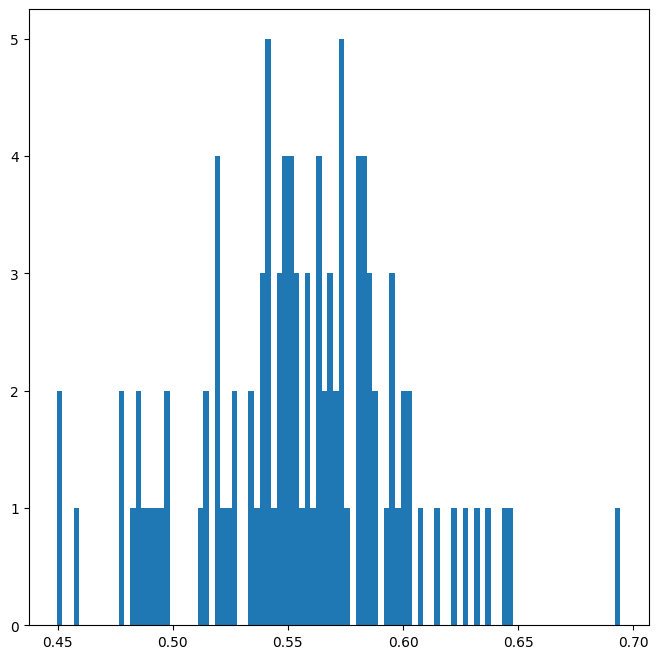

In [15]:
fig, ax = subplots(figsize=(8,8))
ax.hist(pred[:,1], bins=100)


In [16]:
qda = QDA(store_covariance=True)
qda.fit(X_train, y_train)
pred = qda.predict_proba(X_test)
pred_labels = np.where(pred[:,1] > 0.5, 'Up', 'Down')
confusion_stats(confusion_table(pred_labels, y_test))

accuracy: 0.5865384615384616
true positives: 1.0
true_negatives: 0.0


In [17]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
pred = knn.predict_proba(X_test)
pred_labels = np.where(pred[:,1], 'Up', 'Down')
confusion_stats(confusion_table(pred_labels, y_test))

accuracy: 0.5
true positives: 0.4918032786885246
true_negatives: 0.5116279069767442


In [18]:
nb = GaussianNB()
nb.fit(X_train, y_train)

GaussianNB()

In [19]:
pred = nb.predict(X_test)
pred_labels = np.where(pred, 'Up', 'Down')
confusion_table(pred_labels, y_test)

Truth,Down,Up
Predicted,,
Down,0,0
Up,43,61


In [20]:
for i in range(1, 10):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred = knn.predict_proba(X_test)
    pred_labels = np.where(pred[:,1], 'Up', 'Down')
    print(f'Neighbors: {i} -------------------------------------')
    confusion_stats(confusion_table(pred_labels, y_test))

Neighbors: 1 -------------------------------------
accuracy: 0.5
true positives: 0.4918032786885246
true_negatives: 0.5116279069767442
Neighbors: 2 -------------------------------------
accuracy: 0.5769230769230769
true positives: 0.8360655737704918
true_negatives: 0.20930232558139536
Neighbors: 3 -------------------------------------
accuracy: 0.5769230769230769
true positives: 0.9016393442622951
true_negatives: 0.11627906976744186
Neighbors: 4 -------------------------------------
accuracy: 0.5865384615384616
true positives: 0.9508196721311475
true_negatives: 0.06976744186046512
Neighbors: 5 -------------------------------------
accuracy: 0.5865384615384616
true positives: 0.9672131147540983
true_negatives: 0.046511627906976744
Neighbors: 6 -------------------------------------
accuracy: 0.5865384615384616
true positives: 0.9836065573770492
true_negatives: 0.023255813953488372
Neighbors: 7 -------------------------------------
accuracy: 0.5865384615384616
true positives: 0.9836065573

# Auto - milelage data

In [21]:
auto = load_data('Auto')
auto.shape

(392, 9)

In [22]:
median = auto.mpg.median()
auto['mpg01'] = np.where(auto.mpg > median, 1, 0)
auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name,mpg01
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu,0
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320,0
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite,0
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst,0
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino,0


<Axes: xlabel='cylinders', ylabel='mpg01'>

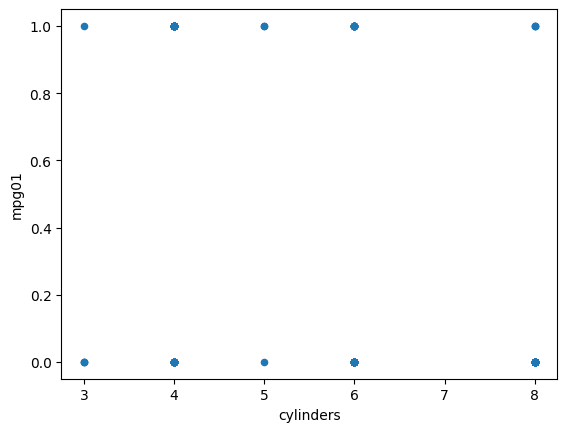

In [23]:
attribute = 'cylinders'
auto.plot.scatter(y='mpg01', x=attribute)


In [24]:
train_df = auto.drop(columns=['mpg', 'mpg01', 'year', 'cylinders', 'name'])
X_train, X_test, y_train, y_test = train_test_split(train_df, auto['mpg01'], test_size=50, random_state=0)
X_train

,displacement,horsepower,weight,acceleration,origin
146,116.0,75,2246,14.0,2
10,383.0,170,3563,10.0,1
26,307.0,200,4376,15.0,1
45,140.0,72,2408,19.0,1
315,97.0,78,2188,15.8,2
...,...,...,...,...,...
323,90.0,48,2085,21.7,2
192,232.0,90,3085,17.6,1
117,116.0,75,2158,15.5,2
47,250.0,88,3139,14.5,1


In [25]:
# performing LDA
lda = LDA(store_covariance=True)
lda.fit(X_train, y_train)
pred = lda.predict(X_test)
pred_labels = np.where(pred > 0.5, 1, 0)
ct = confusion_table(pred_labels, y_test)
confusion_stats(ct)

accuracy: 0.86
true positives: 0.9545454545454546
true_negatives: 0.7857142857142857


In [26]:
qda = QDA(store_covariance=True)
qda.fit(X_train, y_train)
pred = qda.predict(X_test)
pred_labels = np.where(pred > 0.5, 1, 0)
ct = confusion_table(pred_labels, y_test)
confusion_stats(ct)

accuracy: 0.88
true positives: 0.9545454545454546
true_negatives: 0.8214285714285714


In [27]:
design2 = MS(X_train.columns)
design2.fit_transform(X_train)
model = sm.GLM(y_train, X_train, family=sm.families.Binomial())
results = model.fit()
pred = results.predict(exog=X_test)

pred_labels = np.where(pred > 0.5, 1, 0)
confusion_table(pred_labels, y_test)

Truth,0,1
Predicted,,
0,22,1
1,6,21


In [28]:
NB = GaussianNB()
NB.fit(X_train, y_train)
pred = NB.predict(X_test)
pred_labels = np.where(pred > 0.5, 1, 0)
confusion_table(pred_labels, y_test)

Truth,0,1
Predicted,,
0,22,1
1,6,21


In [29]:
i = 4
knn = KNeighborsClassifier(n_neighbors=i)
knn.fit(X_train, y_train)
pred = knn.predict(X_test)
confusion_table(pred, y_test)

Truth,0,1
Predicted,,
0,25,2
1,3,20


# writing functions in python

In [30]:
def Power():
    print(2 ** 3)

def Power2(x, a):
    print(x ** a)

def Power3(x, a):
    return x ** a


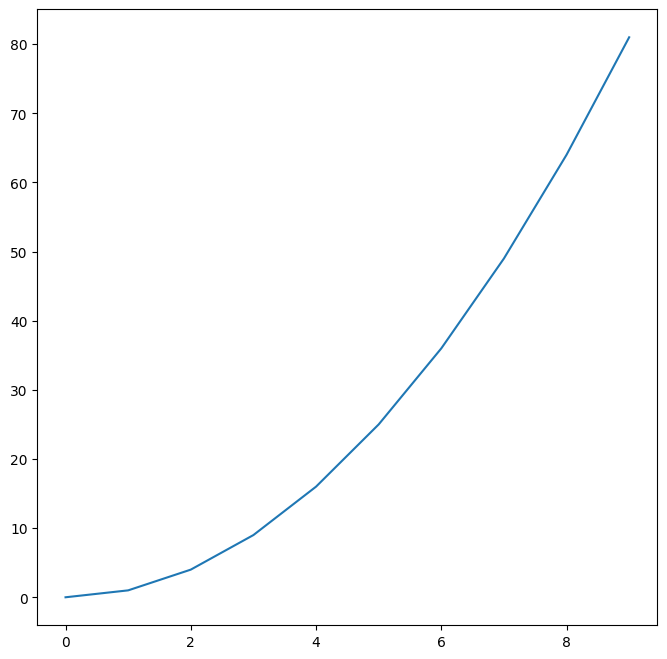

In [31]:
fig, ax = subplots(figsize=(8,8))
x = np.arange(10)
y = np.array(list(map(lambda x_i: Power3(x_i, 2), x)))

ax.plot(x, y)

# Boston Suburb

In [32]:
Boston = load_data('Boston')
Boston.head()

# train: 406, test: 100

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2


In [33]:
Boston.corr()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
crim,1.000000,-0.200469,0.406583,-0.055892,0.420972,-0.219247,0.352734,-0.379670,0.625505,0.582764,0.289946,0.455621,-0.388305
zn,-0.200469,1.000000,-0.533828,-0.042697,-0.516604,0.311991,-0.569537,0.664408,-0.311948,-0.314563,-0.391679,-0.412995,0.360445
indus,0.406583,-0.533828,1.000000,0.062938,0.763651,-0.391676,0.644779,-0.708027,0.595129,0.720760,0.383248,0.603800,-0.483725
chas,-0.055892,-0.042697,0.062938,1.000000,0.091203,0.091251,0.086518,-0.099176,-0.007368,-0.035587,-0.121515,-0.053929,0.175260
nox,0.420972,-0.516604,0.763651,0.091203,1.000000,-0.302188,0.731470,-0.769230,0.611441,0.668023,0.188933,0.590879,-0.427321
rm,-0.219247,0.311991,-0.391676,0.091251,-0.302188,1.000000,-0.240265,0.205246,-0.209847,-0.292048,-0.355501,-0.613808,0.695360
age,0.352734,-0.569537,0.644779,0.086518,0.731470,-0.240265,1.000000,-0.747881,0.456022,0.506456,0.261515,0.602339,-0.376955
dis,-0.379670,0.664408,-0.708027,-0.099176,-0.769230,0.205246,-0.747881,1.000000,-0.494588,-0.534432,-0.232471,-0.496996,0.249929
rad,0.625505,-0.311948,0.595129,-0.007368,0.611441,-0.209847,0.456022,-0.494588,1.000000,0.910228,0.464741,0.488676,-0.381626
tax,0.582764,-0.314563,0.720760,-0.035587,0.668023,-0.292048,0.506456,-0.534432,0.910228,1.000000,0.460853,0.543993,-0.468536


array([[<Axes: xlabel='crim', ylabel='crim'>,
        <Axes: xlabel='zn', ylabel='crim'>,
        <Axes: xlabel='indus', ylabel='crim'>,
        <Axes: xlabel='chas', ylabel='crim'>,
        <Axes: xlabel='nox', ylabel='crim'>,
        <Axes: xlabel='rm', ylabel='crim'>,
        <Axes: xlabel='age', ylabel='crim'>,
        <Axes: xlabel='dis', ylabel='crim'>,
        <Axes: xlabel='rad', ylabel='crim'>,
        <Axes: xlabel='tax', ylabel='crim'>,
        <Axes: xlabel='ptratio', ylabel='crim'>,
        <Axes: xlabel='lstat', ylabel='crim'>,
        <Axes: xlabel='medv', ylabel='crim'>],
       [<Axes: xlabel='crim', ylabel='zn'>,
        <Axes: xlabel='zn', ylabel='zn'>,
        <Axes: xlabel='indus', ylabel='zn'>,
        <Axes: xlabel='chas', ylabel='zn'>,
        <Axes: xlabel='nox', ylabel='zn'>,
        <Axes: xlabel='rm', ylabel='zn'>,
        <Axes: xlabel='age', ylabel='zn'>,
        <Axes: xlabel='dis', ylabel='zn'>,
        <Axes: xlabel='rad', ylabel='zn'>,
        <Axes: x

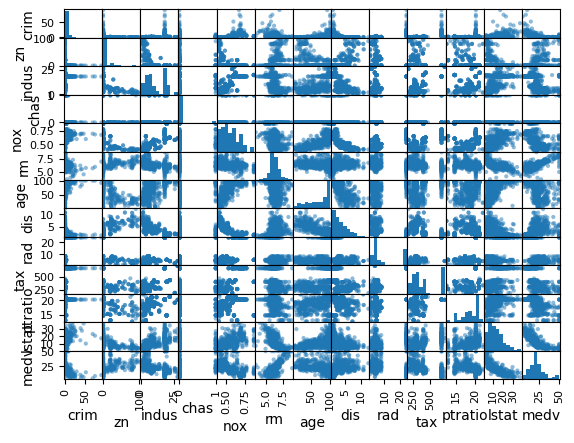

In [34]:
pd.plotting.scatter_matrix(Boston)

In [35]:
median_crime_rate = Boston.crim.median()
crim_binary = np.where(Boston.crim >= median_crime_rate, True, False)
feature_df = Boston.drop(columns=['crim'])
X_train, X_test, y_train, y_test = train_test_split(feature_df, crim_binary, test_size=150, random_state=0)

In [36]:
design = MS(X_train)
design.fit_transform(X_train)

model = sm.GLM(y_train, X_train, family=sm.families.Binomial())
pred = model.fit()
summarize(pred)

,coef,std err,z,P>|z|
zn,-0.0566,0.028,-2.037,0.042
indus,-0.0210,0.041,-0.511,0.609
chas,0.1372,0.754,0.182,0.856
nox,14.8405,4.547,3.264,0.001
rm,-0.9802,0.621,-1.578,0.115
age,0.0249,0.012,2.045,0.041
dis,-0.2055,0.192,-1.069,0.285
rad,0.4508,0.137,3.290,0.001
tax,-0.0063,0.003,-2.292,0.022
ptratio,-0.1722,0.106,-1.623,0.105


In [38]:
results = pred.predict(exog=X_test)
pred_labels = np.where(results > 0.5, 1, 0)
confusion_stats(confusion_table(pred_labels, y_test))

accuracy: 0.8933333333333333
true positives: 0.9041095890410958
true_negatives: 0.8831168831168831


In [40]:
feature_df2 = feature_df.drop(columns=['chas', 'lstat', 'medv', 'indus'])
X_train, X_test, y_train, y_test = train_test_split(feature_df2, crim_binary, test_size=150, random_state=0)

design = MS(X_train)
design.fit_transform(X_train)

model = sm.GLM(y_train, X_train, family=sm.families.Binomial())
pred = model.fit()
summarize(pred)

,coef,std err,z,P>|z|
zn,-0.0584,0.027,-2.177,0.030
nox,13.3525,3.966,3.367,0.001
rm,-0.6610,0.247,-2.675,0.007
age,0.0218,0.010,2.138,0.033
dis,-0.2262,0.174,-1.302,0.193
rad,0.4757,0.132,3.596,0.000
tax,-0.0071,0.003,-2.787,0.005
ptratio,-0.2069,0.084,-2.475,0.013


In [42]:
results = pred.predict(exog=X_test)
pred_labels = np.where(results > 0.5, 1, 0)
confusion_table(pred_labels, y_test)

Truth,0,1
Predicted,,
0,69,7
1,8,66
